In [3]:
import pandas as pd
import numpy as np
import datetime as dtm
import plotly.express as px

# Data

In [30]:
from algorithmic_trading.data_handler import YFinanceData

dobj = YFinanceData(ticker='PAYTM.NS', start_date=dtm.date(2020, 1, 1))

In [31]:
df = dobj.get_data(fields=['Open', 'High', 'Low', 'Close'])
df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open
2021-11-18,1560.800049,1955.000000,1560.000000,1950.000000
2021-11-22,1359.599976,1519.000000,1271.000000,1509.000000
2021-11-23,1494.699951,1525.000000,1360.000000,1360.000000
2021-11-24,1752.449951,1785.000000,1502.949951,1503.000000
2021-11-25,1798.750000,1873.699951,1711.099976,1766.699951
...,...,...,...,...
2025-01-06,969.049988,1000.000000,964.250000,985.000000
2025-01-07,983.200012,995.849976,972.000000,972.000000
2025-01-08,902.049988,987.250000,895.150024,986.000000
2025-01-09,894.650024,911.700012,890.099976,900.000000


## Build Strategy

In [32]:
from algorithmic_trading.strategy import MyStrategy

ms = MyStrategy(df)

In [33]:
def strategy_pre_build(obj):
    obj.df['Range'] = obj.df.High - obj.df.Low
    obj.df['Distance'] = abs(obj.df.Close - obj.df.Low)
    obj.df['Close percentage'] = (obj.df.Distance / obj.df.Range) * 100

In [34]:
def signal(obj, close_pct_threshold, range_value, in_place=True):
    _long = np.where(
        (obj.df['Close percentage'] < close_pct_threshold) &
        (obj.df['Range'] > range_value),
        True, False)

    df_long = pd.DataFrame({'Long': _long}, index=df.index)

    df_long['Sys_ret'] = np.where(df_long.Long.shift(1) == True, df.Return, 1)
    df_long['Sys_bal'] = df_long.Sys_ret.cumprod() * obj.START_BAL

    if in_place:
        obj.df = pd.concat([obj.df, df_long], axis=1)
    else:
        return df_long

In [35]:
ms.run(strategy_pre_build, signal, close_pct_threshold=20, range_value=20)

In [36]:
ms.df

,Close,High,Low,Open,Return,Benchmark_bal,Benchmark_pct,Range,Distance,Close percentage,Long,Sys_ret,Sys_bal
2021-11-18,1560.800049,1955.000000,1560.000000,1950.000000,1.000000,1000.000000,0.000,395.000000,0.800049,0.202544,True,1.000000,1000.000000
2021-11-22,1359.599976,1519.000000,1271.000000,1509.000000,0.871092,871.091705,-12.891,248.000000,88.599976,35.725797,False,0.871092,871.091705
2021-11-23,1494.699951,1525.000000,1360.000000,1360.000000,1.099367,957.649862,-4.235,165.000000,134.699951,81.636334,False,1.000000,871.091705
2021-11-24,1752.449951,1785.000000,1502.949951,1503.000000,1.172443,1122.789529,12.279,282.050049,249.500000,88.459478,False,1.000000,871.091705
2021-11-25,1798.750000,1873.699951,1711.099976,1766.699951,1.026420,1152.453834,15.245,162.599976,87.650024,53.905312,False,1.000000,871.091705
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-06,969.049988,1000.000000,964.250000,985.000000,0.986009,620.867477,-37.913,35.750000,4.799988,13.426539,True,0.986009,617.036882
2025-01-07,983.200012,995.849976,972.000000,972.000000,1.014602,629.933356,-37.007,23.849976,11.200012,46.960267,False,1.014602,626.046827
2025-01-08,902.049988,987.250000,895.150024,986.000000,0.917463,577.940774,-42.206,92.099976,6.899963,7.491819,True,1.000000,626.046827
2025-01-09,894.650024,911.700012,890.099976,900.000000,0.991797,573.199639,-42.680,21.600037,4.550049,21.065005,False,0.991797,620.911054


## Benchmark Stats

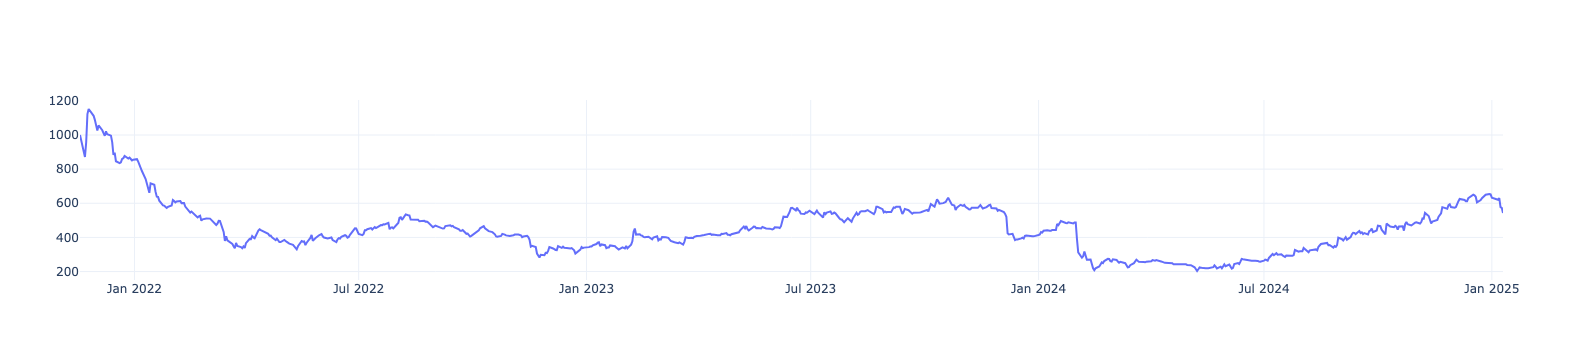

In [37]:
from algorithmic_trading.plotly_handler import plot_plotly

plot_plotly(ms.df.Benchmark_bal)

## Strategy Stats

In [38]:
ms.stats()

Total Days               778.000
Market Exposure           21.470
# of Trades              119.000
Benchmark WinRate         46.641
Strategy WinRate          44.848
Benchmark Return (Rs)    543.500
Benchmark Return (%)     -45.650
Strategy Return (Rs)     620.910
Strategy Return (%)      -37.910
dtype: float64

# Strategy vs benchmark comparisons

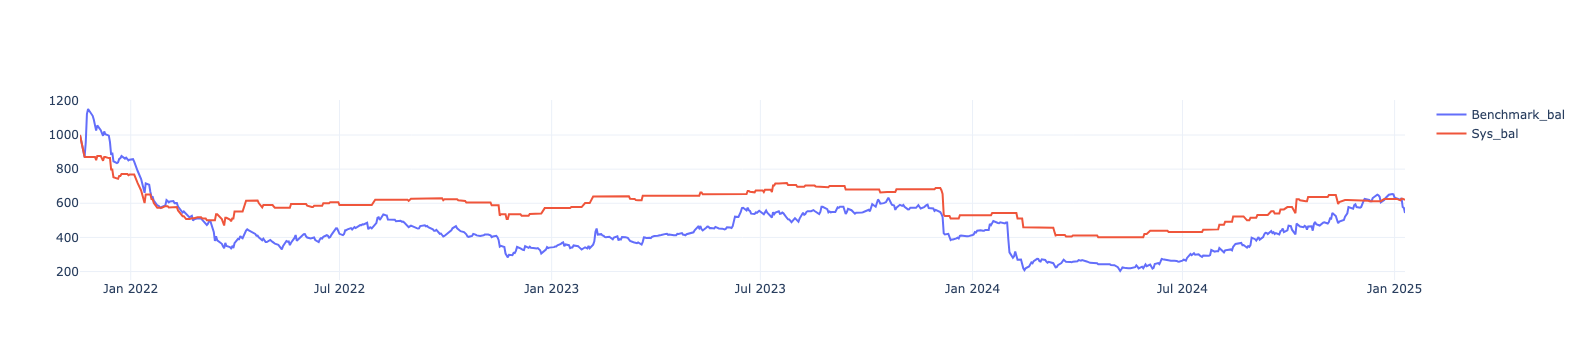

In [41]:
plot_plotly(ms.df.Benchmark_bal, ms.df.Sys_bal)